In [1]:
import matplotlib.pyplot as plt
import math
from scipy.stats import chi2
from scipy.integrate import quad
from scipy.special import erf
from scipy.stats import expon
import numpy as np
import pandas as pd

In [2]:
# числові характеристики

def deviation(df):
    avg = x_average(df)
    df_t = df.copy()
    
    df_t['dev'] = ((df_t['zi'] - avg) ** 2) * df_t['ni']
    return df_t['dev'].sum()

def variance(df): 
    return deviation(df) / (df['ni'].sum() - 1)

def get_standart(df):
    return variance(df) ** 0.5

def count_zi(df):
    df['zi'] = df['xi'].apply(lambda x: (x[1] + x[0]) / 2)
    
    return df

def x_average(df):
    df_t = df.copy()
    df_t['avg'] = df_t['zi'] * df_t['ni']
    return df_t['avg'].sum() / df_t['ni'].sum()

def get_lambda(df):
    return 1 / x_average(df)

# round4 = lambda x: round(x, 4)

In [3]:
# обчислити Х2 емпіричне та критичне

def count_x2_empirical(df):
    df_t = df.copy()
    df_t['emp'] = (df_t['ni'] - df_t['ni'].sum() * df_t['pi']) ** 2 / (df_t['ni'].sum() * df_t['pi'])
    return df_t['emp'].sum()

def count_x2_critical(alpha, df):
    return chi2.ppf(1 - alpha, df)

In [4]:
def laplace_integral_function(x):
    return erf(x / 2 ** 0.5) / 2

In [5]:
def parse_interval(x):
    splitted = x.split('-')
    return (float(splitted[0]), float(splitted[1]))

In [6]:
# Задача 1

df = pd.read_csv('task1.csv')
df.iloc[:, 0] = df.iloc[:, 0].apply(parse_interval)

df = count_zi(df)
print("Вибірка:")
df

Вибірка:


,xi,ni,zi
0,"(170.0, 180.0)",4,175.0
1,"(180.0, 190.0)",7,185.0
2,"(190.0, 200.0)",28,195.0
3,"(200.0, 210.0)",56,205.0
4,"(210.0, 220.0)",70,215.0
5,"(220.0, 230.0)",60,225.0
6,"(230.0, 240.0)",52,235.0
7,"(240.0, 250.0)",26,245.0
8,"(250.0, 260.0)",10,255.0
9,"(260.0, 270.0)",6,265.0


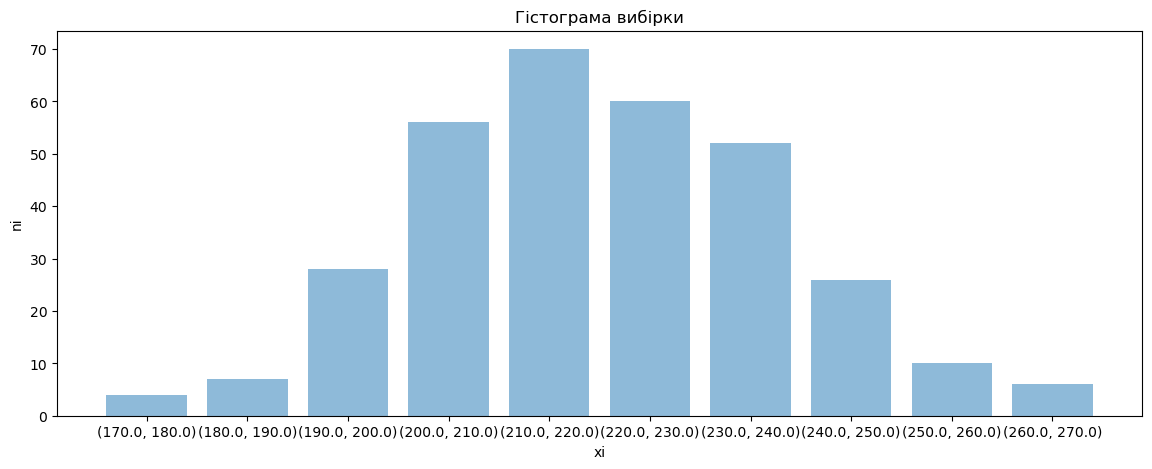

In [7]:
# гістограма

plt.figure(figsize=(14,5))
plt.bar(df['xi'].astype(str), df['ni'], align='center', alpha=0.5)
plt.xlabel('xi')
plt.ylabel('ni')
plt.title('Гістограма вибірки')
plt.show()

In [8]:
# знайти ймовірності - нормальний зр

def find_probabilities_normal(df, x_average, standart):
    min_x = df['xi'][0][0]
    max_x = df['xi'][len(df) - 1][1]
    
    def find_probability(row):
        x = row['xi']
        if x[0] == min_x:
            return laplace_integral_function((x[1] - x_average) / standart) - laplace_integral_function(-np.inf)
        
        elif x[1] == max_x:
            return laplace_integral_function(np.inf) - laplace_integral_function((x[0] - x_average) / standart)
        
        else:
            return laplace_integral_function((x[1] - x_average) / standart) - laplace_integral_function((x[0] - x_average) / standart)
        
    df['pi'] = df.apply(find_probability, axis=1)

    return df

In [9]:
# об'єднати класи, якщо не виконуються умови

def combine_rows(df):
    is_valid = False
    
    while not is_valid:
        for i in range(df.shape[0]):
            if df.iloc[i]['ni'] < 5 or df.iloc[i]['ni'] * df.iloc[i]['pi'] < 10:
                is_valid = False
                
                if i == 0 or i <= df.shape[0]//2:   
                    res1 = df.iloc[[i, i+1], :]
                    res1['xi'] = ((res1['xi'].iloc[0][0], res1['xi'].iloc[1][1]), (res1['xi'].iloc[0][0], res1['xi'].iloc[1][1]))
                    res1['ni'] = res1['ni'].sum()
                    res1['pi'] = res1['pi'].sum()
                    res1 = res1.drop_duplicates()

                    df = pd.concat([df.drop([i, i+1], axis=0), res1]).reset_index(drop=True)
                    df = df.sort_values(by='xi').reset_index(drop=True)

                    break

                else:
                    res1 = df.iloc[[i-1, i], :]
                    
                    res1['xi'] = ((res1['xi'].iloc[0][0], res1['xi'].iloc[1][1]), (res1['xi'].iloc[0][0], res1['xi'].iloc[1][1]))
                    res1['ni'] = res1['ni'].sum()
                    res1['pi'] = res1['pi'].sum()
                    res1 = res1.drop_duplicates()
                    
                    df = pd.concat([df.drop([i-1, i], axis=0), res1]).reset_index(drop=True)
                    df = df.sort_values(by='xi').reset_index(drop=True)

                    break
            is_valid = True
    return df

In [10]:
print("Гіпотеза H0: закон розподілу нормальний")

param_check = input("Вводити параметри вручну чи оцінити? (вручну / оцінити)")
if(param_check == "вручну"):
    x_avg = float(input("Введіть x середнє: "))
    stand = float(input("Введіть стандарт: "))
    d_f = 2
else:
    x_avg = x_average(df)
    stand = get_standart(df)
    d_f = 0

alpha = float(input(("Введіть рівень значущості: ")))

print(f"\nХ середнє: {x_avg}, стандарт: {stand}")

df = find_probabilities_normal(df, x_avg, stand)
print("\nТаблиця з обчисленими ймовірностями:")
df

Гіпотеза H0: закон розподілу нормальний


Вводити параметри вручну чи оцінити? (вручну / оцінити) оцінити
Введіть рівень значущості:  0.05



Х середнє: 220.10971786833855, стандарт: 17.942181762487493

Таблиця з обчисленими ймовірностями:


,xi,ni,zi,pi
0,"(170.0, 180.0)",4,175.0,0.012692
1,"(180.0, 190.0)",7,185.0,0.033966
2,"(190.0, 200.0)",28,195.0,0.084526
3,"(200.0, 210.0)",56,205.0,0.155375
4,"(210.0, 220.0)",70,215.0,0.211000
5,"(220.0, 230.0)",60,225.0,0.211702
6,"(230.0, 240.0)",52,235.0,0.156931
7,"(240.0, 250.0)",26,245.0,0.085942
8,"(250.0, 260.0)",10,255.0,0.034766
9,"(260.0, 270.0)",6,265.0,0.013099


In [11]:
df = df.drop('zi', axis=1)

In [22]:
print("Таблиця після об'єднання класів:")

df = combine_rows(df)
df

Таблиця після об'єднання класів:


,xi,ni,pi
0,"(170.0, 210.0)",95,0.286561
1,"(210.0, 220.0)",70,0.211000
2,"(220.0, 230.0)",60,0.211702
3,"(230.0, 270.0)",94,0.290738


In [13]:
x2_emp = count_x2_empirical(df)
print(f"X2 емпіричне: {x2_emp}")

d_f += df.shape[0] -1 -2
x2_crit = count_x2_critical(alpha, d_f)
print(f"X2 критичне: {x2_crit}")

if(x2_emp < x2_crit):
    print("Емпіричне < критичне - гіпотезу Н0 приймаємо")
else:
    print("Емпіричне > критичне - гіпотезу Н0 відхиляємо")

X2 емпіричне: 1.1055730457679123
X2 критичне: 3.841458820694124
Емпіричне < критичне - гіпотезу Н0 приймаємо


In [14]:
# Задача 2

df2 = pd.read_csv('task2.csv')
df2.iloc[:, 0] = df2.iloc[:, 0].apply(parse_interval)

print("Вибірка:")
df2 = count_zi(df2)
df2

Вибірка:


,xi,ni,zi
0,"(0.0, 6.0)",534,3.0
1,"(6.0, 12.0)",384,9.0
2,"(12.0, 18.0)",276,15.0
3,"(18.0, 24.0)",211,21.0
4,"(24.0, 30.0)",162,27.0
5,"(30.0, 36.0)",116,33.0
6,"(36.0, 42.0)",82,39.0
7,"(42.0, 48.0)",63,45.0
8,"(48.0, 54.0)",46,51.0
9,"(54.0, 60.0)",34,57.0


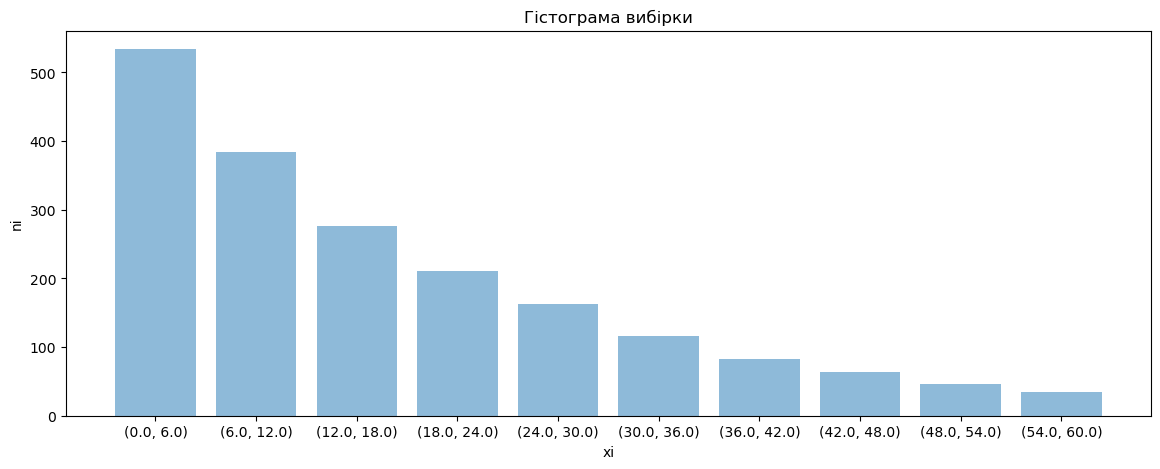

In [15]:
# гістограма

plt.figure(figsize=(14,5))
plt.bar(df2['xi'].astype(str), df2['ni'], align='center', alpha=0.5)
plt.xlabel('xi')
plt.ylabel('ni')
plt.title('Гістограма вибірки')
plt.show()

In [16]:
def F_exp(x, lamb):
        return 1 - np.exp(-lamb * x)

In [17]:
# знайти ймовірності - експонентний зр

def find_probabilities_exponential(df, lamb):
    max_x = df['xi'][len(df) - 1][1] # 60
    
    def find_probability_exp(row):
        x = row['xi']
        
        if(x[1] == max_x):
            return 0
        else:
            return F_exp(x[1], lamb) - F_exp(x[0], lamb)
            
    
    df['pi'] = df.apply(find_probability_exp, axis=1)
    
    last_value = 1 - df.iloc[:-1]['pi'].sum()
    df.iloc[-1, 3] = last_value
    
    return df

In [18]:
print("Гіпотеза H0: закон розподілу експонентний")

param_check_exp = input("Вводити параметри вручну чи оцінити? (вручну / оцінити)")
if(param_check_exp == "вручну"):
    lamb = float(input("Введіть лямбду: "))
    d_f_exp = 1
else:
    lamb = get_lambda(df2)
    d_f_exp = 0

alpha_exp = float(input(("Введіть рівень значущості: ")))

print(f"\nЛямбда: {lamb}")

df2 = find_probabilities_exponential(df2, lamb)
print("\nТаблиця з обчисленими ймовірностями:")
df2

Гіпотеза H0: закон розподілу експонентний


Вводити параметри вручну чи оцінити? (вручну / оцінити) оцінити
Введіть рівень значущості:  0.03



Лямбда: 0.0593505039193729

Таблиця з обчисленими ймовірностями:


,xi,ni,zi,pi
0,"(0.0, 6.0)",534,3.0,0.299600
1,"(6.0, 12.0)",384,9.0,0.209840
2,"(12.0, 18.0)",276,15.0,0.146972
3,"(18.0, 24.0)",211,21.0,0.102939
4,"(24.0, 30.0)",162,27.0,0.072099
5,"(30.0, 36.0)",116,33.0,0.050498
6,"(36.0, 42.0)",82,39.0,0.035369
7,"(42.0, 48.0)",63,45.0,0.024772
8,"(48.0, 54.0)",46,51.0,0.017351
9,"(54.0, 60.0)",34,57.0,0.040562


In [19]:
df2 = df2.drop('zi', axis=1)

In [23]:
print("Таблиця після об'єднання класів:")

df2 = combine_rows(df2)
df2

Таблиця після об'єднання класів:


,xi,ni,pi
0,"(0.0, 6.0)",534,0.299600
1,"(6.0, 12.0)",384,0.209840
2,"(12.0, 18.0)",276,0.146972
3,"(18.0, 24.0)",211,0.102939
4,"(24.0, 30.0)",162,0.072099
5,"(30.0, 60.0)",341,0.168551


In [21]:
x2_emp_exp = count_x2_empirical(df2)
print(f"X2 емпіричне: {x2_emp_exp}")

d_f_exp += df2.shape[0] -1 -1
x2_crit_exp = count_x2_critical(alpha_exp, d_f_exp)
print(f"X2 критичне: {x2_crit_exp}")

if(x2_emp_exp < x2_crit_exp):
    print("Емпіричне < критичне - гіпотезу Н0 приймаємо")
else:
    print("Емпіричне > критичне - гіпотезу Н0 відхиляємо")

X2 емпіричне: 9.812818484315112
X2 критичне: 10.711898289670378
Емпіричне < критичне - гіпотезу Н0 приймаємо
